<a href="https://colab.research.google.com/github/imansrf/CTScans-for-Covid19-Classification/blob/main/CTScans_for_Covid19_Classification_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Akhir : Klasifikasi Citra CT Scan Dada untuk Covid-19

Proyek ini akan melakukan klasifikasi terhadap CT Scan Dada untuk mengidentifikasi Covid-19 dengan menggunakan metode CNN, dan kemudian model tersebut akan dikonversikan ke dalam format .tflite

Berikut link kaggle untuk dataset yang digunakan :
https://www.kaggle.com/azaemon/preprocessed-ct-scans-for-covid19

# Tahap Persiapan

## Mengimpor library

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools
import shutil
from tqdm.notebook import tqdm as tq

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.util import random_noise

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

import random

## Menginstall Fungsi Autotime

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 176 µs (started: 2021-07-14 08:32:11 +00:00)


# Tahap Impor Dataset

Pada tahap mengimpor dataset, kita menggunakan fungsi API untuk mengunduh dataset dari Kaggle

## Menginstal Kaggle di Colab

In [3]:
!pip install kaggle

time: 3.86 s (started: 2021-07-14 08:32:11 +00:00)


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rokhiimansarofi","key":"0cfb79c99bf150bbbe869a445ebe88ba"}'}

time: 31.9 s (started: 2021-07-14 08:32:15 +00:00)


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

time: 362 ms (started: 2021-07-14 08:32:47 +00:00)


## Mengimpor Dataset Kaggle

In [6]:
!kaggle datasets download -d azaemon/preprocessed-ct-scans-for-covid19

100% 3.58G/3.59G [01:18<00:00, 98.3MB/s]
100% 3.59G/3.59G [01:18<00:00, 49.2MB/s]
time: 1min 19s (started: 2021-07-14 08:32:47 +00:00)


In [7]:
!unzip \*.zip  && rm *.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Preprocessed CT scans/nCT/nCT9082.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9083.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9084.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9085.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9086.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9087.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9088.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9089.jpg  
  inflating: Preprocessed CT scans/nCT/nCT909.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9090.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9091.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9092.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9093.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9094.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9095.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9096.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9097.jpg  
  inflating: Preprocessed CT scans/nCT/nC

# Tahap Preprocessing Dataset

## Membuat Dataframe untuk Dataset

In [8]:
mypath= 'Original CT Scans/'

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

time: 76.1 ms (started: 2021-07-14 08:35:42 +00:00)


In [9]:
# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
NiCT    5705
nCT     9979
pCT     4001
dtype: int64

time: 55.9 ms (started: 2021-07-14 08:35:42 +00:00)


## Membagi Dataset ke Dalam Bentuk Train Data dan Test Data

In [10]:
#load library untuk train test split
from sklearn.model_selection import train_test_split

#variabel yang digunakan pada pemisahan data ini
X= df['path']
y= df['tag']

# split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

time: 17.5 ms (started: 2021-07-14 08:35:42 +00:00)


In [11]:
# menyatukan kedalam masing-masing dataframe

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

time: 12.4 ms (started: 2021-07-14 08:35:42 +00:00)


In [12]:
print('train size', len(df_tr))
print('test size', len(df_te))

train size 15748
test size 3937
time: 1.64 ms (started: 2021-07-14 08:35:42 +00:00)


In [13]:
# melihat proporsi pada masing masing set apakah sudah ok atau masih ada yang ingin diubah
df_all = df_tr.append([df_te]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

#cek sample datanya
df_all.sample(3)


set    tag 
test   NiCT    1191
       nCT     1977
       pCT      769
train  NiCT    4514
       nCT     8002
       pCT     3232
dtype: int64 




,path,tag,set
16745,Original CT Scans/NiCT/NiCT2259.jpg,NiCT,test
6312,Original CT Scans/pCT/pCT2171.jpg,pCT,train
3691,Original CT Scans/NiCT/NiCT1119.jpg,NiCT,train


time: 62.6 ms (started: 2021-07-14 08:35:42 +00:00)


## Membuat Folder Baru untuk Dataset

In [14]:
## create folders
os.makedirs('Dataset/')

time: 1.22 ms (started: 2021-07-14 08:35:42 +00:00)


## Menyalin Dataset ke dalam Folder Dataset Baru

In [15]:
datasource_path = "Original CT Scans/"
dataset_path = "Dataset/"

for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)


time: 1min 28s (started: 2021-07-14 08:35:43 +00:00)


## Augmentasi Data

In [16]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.2,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.1,    
    vertical_flip = True,
    fill_mode = "nearest")

time: 2.69 ms (started: 2021-07-14 08:37:11 +00:00)


## Memuat Dataset

In [17]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 126
base_dir = os.path.join('Dataset/train/')



train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training',
    class_mode= 'categorical')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation',
    class_mode= 'categorical')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['NiCT',
          'nCT',
          'pCT',]

for i,label in enumerate(labels):
    folder = os.path.join("Dataset/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 12600 images belonging to 3 classes.
Found 3148 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (126, 224, 224, 3) (126, 3)
Bentuk array dari dataset validation (validasi) adalah: (126, 224, 224, 3) (126, 3)
Bentuk array dari dataset test (pengujian) adalah: (3937, 224, 224, 3) (3937,)
time: 6min 18s (started: 2021-07-14 08:37:11 +00:00)


## Menyimpan label

In [18]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'NiCT': 0, 'nCT': 1, 'pCT': 2}
time: 2.85 ms (started: 2021-07-14 08:43:29 +00:00)


In [19]:
!cat labels.txt

NiCT
nCT
pCTtime: 380 ms (started: 2021-07-14 08:43:29 +00:00)


# Tahap Pemodelan

## Transfer Learning

In [51]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_99[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

## Merancang Model Sequential

In [55]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
]
)

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 3, 3, 32)          589856    
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3, 32)          0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
Total params: 22,392,739
Trainable params: 589,955
Non-trainable params: 21,802,784
_________________________________________________________________
time: 1.29 s (started: 2021-07-14 11:10:45 +00:00)


## Menggunakan Fungsi Callback

In [56]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.93):
      print("\nAkurasi telah sesuai!")
      self.model.stop_training = True
callbacks = myCallback()

time: 4.21 ms (started: 2021-07-14 11:11:03 +00:00)


# Tahap Pelatihan

## Melatih Model

In [57]:
history = model.fit_generator(train_generator, 
                    epochs=10, 
                    validation_data=val_generator,
                    callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 351s 3s/step - loss: 0.8538 - acc: 0.7668 - val_loss: 0.5118 - val_acc: 0.7903
Epoch 2/10
100/100 [==============================] - 305s 3s/step - loss: 0.3793 - acc: 0.8548 - val_loss: 0.4507 - val_acc: 0.8523
Epoch 3/10
100/100 [==============================] - 304s 3s/step - loss: 0.3461 - acc: 0.8890 - val_loss: 0.3896 - val_acc: 0.9273
Epoch 4/10
100/100 [==============================] - 305s 3s/step - loss: 0.3171 - acc: 0.9116 - val_loss: 0.4347 - val_acc: 0.9022
Epoch 5/10
100/100 [==============================] - 311s 3s/step - loss: 0.2887 - acc: 0.9229 - val_loss: 0.3459 - val_acc: 0.9355

Akurasi telah sesuai!
time: 26min 18s (started: 2021-07-14 11:11:05 +00:00)


## Menampilkan Hasil Pelatihan

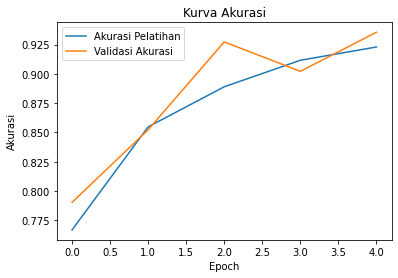

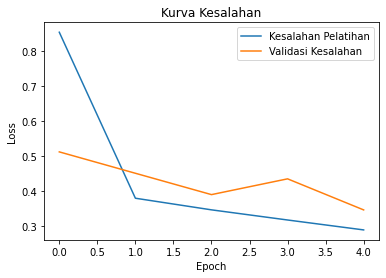

time: 429 ms (started: 2021-07-14 11:38:47 +00:00)


In [59]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.title('Kurva Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.title('Kurva Kesalahan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Tahap Pengujian & Evaluasi

## Memuat Dataset Pengujian

In [60]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

time: 3.01 ms (started: 2021-07-14 11:38:47 +00:00)


## Mengevaluasi Model

In [61]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 ... 2 2 2]
[0 0 0 ... 2 2 2]
time: 24.8 s (started: 2021-07-14 11:38:47 +00:00)


## Menggunakan Model

In [62]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4
time: 1.14 ms (started: 2021-07-14 11:39:12 +00:00)


## Memprediksi Citra Secara Individu

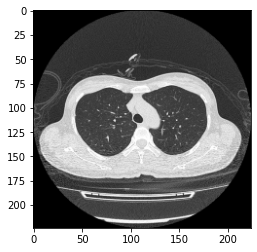

Label yang benar adalah: 1 : nCT
Nilai yang diprediksi adalah: [1.7743268e-09 9.9843377e-01 1.5662611e-03]
Label yang diprediksi adalah: 1 : nCT
Prediksi benar
time: 330 ms (started: 2021-07-14 11:39:12 +00:00)


In [63]:
n = 2578  #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

## Menampilkan Confusion Matrix

Normalized confusion matrix
[[0.99 0.01 0.01]
 [0.03 0.9  0.07]
 [0.01 0.11 0.88]]


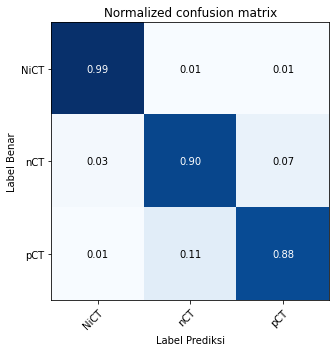

time: 326 ms (started: 2021-07-14 11:39:13 +00:00)


In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

# Tahap Konversi Model

## Menyimpan dan mengkonversi Model ke ".tflite"

In [66]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('CTScans_for_Covid19_Classification_InceptionV3.tflite', 'wb') as f:
  f.write(tflite_model)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: save/model/assets
time: 1min 26s (started: 2021-07-14 11:42:00 +00:00)
